In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import gensim.downloader as api

# Load the dataset
df = pd.read_csv('modified_dataset_for_ML.csv')

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load pre-trained Word2Vec model
w2v_model = api.load("word2vec-google-news-300")

MAX_LEN = 300
EMBEDDING_DIM = 300

def get_word_vector(word):
    try:
        return w2v_model[word]
    except KeyError:
        return np.zeros(EMBEDDING_DIM)

def review_to_tensor(review):
    tokens = review.split()[:MAX_LEN]
    vecs = [get_word_vector(w) for w in tokens]
    if len(vecs) < MAX_LEN:
        vecs += [np.zeros(EMBEDDING_DIM)] * (MAX_LEN - len(vecs))
    return np.array(vecs, dtype=np.float32)

# Dataset Class
class IMDBDataset(Dataset):
    def __init__(self, dataframe):
        self.reviews = dataframe['processed_review'].values
        self.labels = dataframe['sentiment'].values

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review_tensor = review_to_tensor(self.reviews[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return torch.tensor(review_tensor), label

# Dataloaders
batch_size = 64
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = IMDBDataset(train_df)
test_dataset = IMDBDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Bi-directional LSTM Model
class SentimentBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SentimentBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = True

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=self.bidirectional)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for Bi-LSTM
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))  # out: (batch, seq_len, hidden_size * 2)
        out = out[:, -1, :]  # Take output of last time step
        out = self.fc(out)
        return self.sigmoid(out)

# Instantiate Model
model = SentimentBiLSTM(input_size=EMBEDDING_DIM, hidden_size=128, num_layers=1, output_size=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25

best_test_acc = 0.0
best_model_path = "best_bilstm_model.pt"

# Training Loop
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_inputs, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device).unsqueeze(1)

        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation
    def calculate_accuracy(loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        return correct / total

    train_acc = calculate_accuracy(train_loader)
    test_acc = calculate_accuracy(test_loader)

    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), best_model_path)

print(f"Training completed. Best Test Accuracy: {best_test_acc*100:.2f}%")
print(f"Best model saved as {best_model_path}")


Device: cuda
Starting training...


Epoch 1/25: 100%|██████████| 625/625 [01:12<00:00,  8.58it/s]


Epoch 1 Loss: 0.6927, Train Acc: 0.5135, Test Acc: 0.5065


Epoch 2/25: 100%|██████████| 625/625 [00:37<00:00, 16.73it/s]


Epoch 2 Loss: 0.6748, Train Acc: 0.5244, Test Acc: 0.5153


Epoch 3/25: 100%|██████████| 625/625 [00:38<00:00, 16.33it/s]


Epoch 3 Loss: 0.6681, Train Acc: 0.5081, Test Acc: 0.4992


Epoch 4/25: 100%|██████████| 625/625 [00:39<00:00, 16.02it/s]


Epoch 4 Loss: 0.6899, Train Acc: 0.5040, Test Acc: 0.5061


Epoch 5/25: 100%|██████████| 625/625 [00:46<00:00, 13.46it/s]


Epoch 5 Loss: 0.6887, Train Acc: 0.5141, Test Acc: 0.5017


Epoch 6/25: 100%|██████████| 625/625 [00:40<00:00, 15.39it/s]


Epoch 6 Loss: 0.6868, Train Acc: 0.5205, Test Acc: 0.5069


Epoch 7/25: 100%|██████████| 625/625 [00:40<00:00, 15.53it/s]


Epoch 7 Loss: 0.6850, Train Acc: 0.5139, Test Acc: 0.5024


Epoch 8/25: 100%|██████████| 625/625 [00:41<00:00, 14.93it/s]


Epoch 8 Loss: 0.6829, Train Acc: 0.5131, Test Acc: 0.5102


Epoch 9/25: 100%|██████████| 625/625 [00:39<00:00, 15.91it/s]


Epoch 9 Loss: 0.6444, Train Acc: 0.7749, Test Acc: 0.7680


Epoch 10/25: 100%|██████████| 625/625 [00:41<00:00, 15.14it/s]


Epoch 10 Loss: 0.5601, Train Acc: 0.5787, Test Acc: 0.5625


Epoch 11/25: 100%|██████████| 625/625 [00:42<00:00, 14.88it/s]


Epoch 11 Loss: 0.4953, Train Acc: 0.8525, Test Acc: 0.8356


Epoch 12/25: 100%|██████████| 625/625 [00:41<00:00, 15.13it/s]


Epoch 12 Loss: 0.3217, Train Acc: 0.8801, Test Acc: 0.8604


Epoch 13/25: 100%|██████████| 625/625 [00:42<00:00, 14.72it/s]


Epoch 13 Loss: 0.2904, Train Acc: 0.8805, Test Acc: 0.8561


Epoch 14/25: 100%|██████████| 625/625 [00:49<00:00, 12.50it/s]


Epoch 14 Loss: 0.2680, Train Acc: 0.8945, Test Acc: 0.8689


Epoch 15/25: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]


Epoch 15 Loss: 0.2481, Train Acc: 0.9087, Test Acc: 0.8651


Epoch 16/25: 100%|██████████| 625/625 [00:53<00:00, 11.79it/s]


Epoch 16 Loss: 0.2246, Train Acc: 0.9294, Test Acc: 0.8763


Epoch 17/25: 100%|██████████| 625/625 [00:43<00:00, 14.24it/s]


Epoch 17 Loss: 0.1981, Train Acc: 0.9426, Test Acc: 0.8736


Epoch 18/25: 100%|██████████| 625/625 [00:44<00:00, 14.14it/s]


Epoch 18 Loss: 0.1691, Train Acc: 0.9506, Test Acc: 0.8651


Epoch 19/25: 100%|██████████| 625/625 [00:44<00:00, 14.12it/s]


Epoch 19 Loss: 0.1388, Train Acc: 0.9710, Test Acc: 0.8650


Epoch 20/25: 100%|██████████| 625/625 [00:44<00:00, 13.95it/s]


Epoch 20 Loss: 0.1115, Train Acc: 0.9778, Test Acc: 0.8669


Epoch 21/25: 100%|██████████| 625/625 [00:44<00:00, 14.17it/s]


Epoch 21 Loss: 0.0922, Train Acc: 0.9849, Test Acc: 0.8662


Epoch 22/25: 100%|██████████| 625/625 [00:44<00:00, 14.17it/s]


Epoch 22 Loss: 0.0766, Train Acc: 0.9882, Test Acc: 0.8674


Epoch 23/25: 100%|██████████| 625/625 [00:54<00:00, 11.45it/s]


Epoch 23 Loss: 0.0605, Train Acc: 0.9798, Test Acc: 0.8602


Epoch 24/25: 100%|██████████| 625/625 [00:45<00:00, 13.63it/s]


Epoch 24 Loss: 0.0549, Train Acc: 0.9919, Test Acc: 0.8643


Epoch 25/25: 100%|██████████| 625/625 [00:44<00:00, 14.13it/s]


Epoch 25 Loss: 0.0490, Train Acc: 0.9785, Test Acc: 0.8540
Training completed. Best Test Accuracy: 87.63%
Best model saved as best_bilstm_model.pt


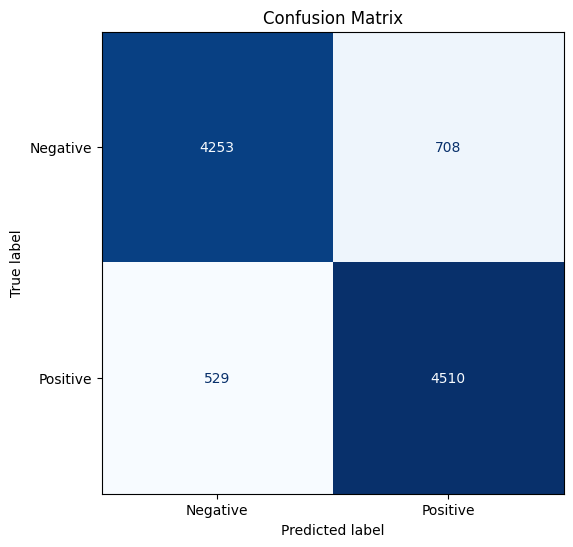

Classification Report:

              precision    recall  f1-score   support

    Negative       0.89      0.86      0.87      4961
    Positive       0.86      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



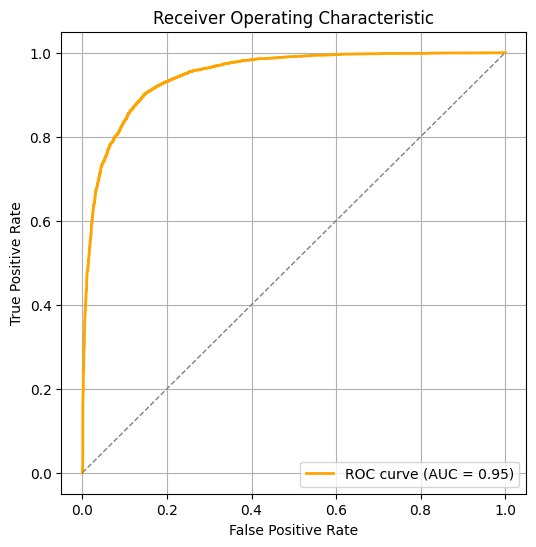

In [2]:

# Load Best Model for Evaluation
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Collect predictions
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        probs = outputs.cpu().numpy().flatten()
        predicted = (outputs > 0.5).float().cpu().numpy().flatten()

        all_preds.extend(predicted)
        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(probs)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [3]:
print(f"Best Test Accuracy: {best_test_acc*100:.2f}%")

Best Test Accuracy: 87.63%
